Use only the data at 2023


In [375]:
import pandas as pd
import numpy as np
import warnings

data_path = "data/"

In [376]:
df = pd.read_csv(f"{data_path}chicago_crime.csv")

In [377]:
df["Date"] = pd.to_datetime(df["Date"])
df_after = df[
    (
        df["Date"].dt.year.isin([2018, 2019, 2020, 2021, 2022, 2023, 2024])
        | (df["Date"].dt.month == 12) & (df["Date"].dt.year == 2017)
    )
]
df_after.isnull().sum()

ID                          0
Case Number                 0
Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     8962
Arrest                      0
Domestic                    0
Beat                        0
District                    1
Ward                       52
Community Area              4
FBI Code                    0
X Coordinate            26318
Y Coordinate            26318
Year                        0
Updated On                  0
Latitude                26318
Longitude               26318
Location                26318
dtype: int64

In [378]:
df_clean = df_after.copy()
df_clean = df_clean.sort_values(by="Date")
df_clean["Date"] = pd.to_datetime(df_clean["Date"], format="%Y-%m-%dT%H:%M:%S.%f")
df_clean["Year"] = df_clean["Date"].dt.year
df_clean["Month"] = df_clean["Date"].dt.month
df_clean["Day"] = df_clean["Date"].dt.day
df_clean["Hour"] = df_clean["Date"].dt.hour
df_clean["WeekDay"] = df_clean["Date"].dt.weekday
df_clean["IsWeekDay"] = (df_clean["WeekDay"] < 5).astype(bool)
df_clean["Isweekend"] = (df_clean["WeekDay"] >= 5).astype(bool)
hour_bins = [0, 6, 12, 18, 24]
hour_labels = ["Night", "Morning", "Afternoon", "Evening"]
season_bins = [0, 3, 6, 9, 12]
season_labels = ["Winter", "Spring", "Summer", "Fall"]
df_clean["TimeCategory"] = pd.cut(
    df_clean["Hour"], bins=hour_bins, labels=hour_labels, include_lowest=True
)
time_dummies = pd.get_dummies(df_clean["TimeCategory"])
df_clean = pd.concat([df_clean, time_dummies], axis=1)
df_clean["Season"] = pd.cut(
    df_clean["Month"], bins=season_bins, labels=season_labels, include_lowest=True
)
df_clean.drop(
    columns=[
        "Community Area",
        "Ward",
        "X Coordinate",
        "Y Coordinate",
        "Latitude",
        "Longitude",
        "Location",
    ],
    inplace=True,
)
df_clean.isnull().sum()

ID                         0
Case Number                0
Date                       0
Block                      0
IUCR                       0
Primary Type               0
Description                0
Location Description    8962
Arrest                     0
Domestic                   0
Beat                       0
District                   1
FBI Code                   0
Year                       0
Updated On                 0
Month                      0
Day                        0
Hour                       0
WeekDay                    0
IsWeekDay                  0
Isweekend                  0
TimeCategory               0
Night                      0
Morning                    0
Afternoon                  0
Evening                    0
Season                     0
dtype: int64

In [380]:
# Standard location categories from your provided list
standard_locations = {
    1: "Abandoned/Condemned Structure",
    2: "Air/Bus/Train Terminal",
    3: "Amusement Park",
    4: "Arena/Stadium/Fairgrounds/Coliseum",
    5: "ATM Separate from Bank",
    6: "Auto Dealership New/Used",
    7: "Bank/Savings and Loan",
    8: "Bar/Nightclub",
    9: "Camp/Campground",
    10: "Church/Synagogue/Temple/Mosque",
    11: "Commercial/Office Building",
    12: "Community Center",
    13: "Construction Site",
    14: "Convenience Store",
    15: "Cyberspace",
    16: "Daycare Facility",
    17: "Department/Discount Store",
    18: "Dock/Wharf/Freight/Modal Terminal",
    19: "Drug Store/Doctor's Office/Hospital",
    20: "Farm Facility",
    21: "Field/Woods",
    22: "Gambling Facility/Casino/Race Track",
    23: "Government/Public Building",
    24: "Grocery/Supermarket",
    25: "Highway/Road/Alley/Street/Sidewalk",
    26: "Hotel/Motel/Etc.",
    27: "Industrial Site",
    28: "Jail/Prison/Penitentiary/Corrections Facility",
    29: "Lake/Waterway/Beach",
    30: "Liquor Store",
    31: "Military Installation",
    32: "Park/Playground",
    33: "Parking/Drop Lot/Garage",
    34: "Rental Storage Facility",
    35: "Residence/Home",
    36: "Rest Area",
    37: "Restaurant",
    38: "School/College",
    39: "School-College/University",
    40: "School-Elementary/Secondary",
    41: "Service/Gas Station",
    42: "Shelter-Mission/Homeless",
    43: "Shopping Mall",
    44: "Specialty Store",
    45: "Tribal Lands",
    98: "Other/Unknown",
    99: "Not Specified",
}
inverse_mapping = {v: k for k, v in standard_locations.items()}

# Mapping from Chicago dataset's location descriptions to the standard categories.
# (The choices below represent one set of reasonable decisions—feel free to adjust them.)
chicago_to_standard = {
    "RESIDENCE": standard_locations[35],
    "SIDEWALK": standard_locations[25],
    "PARKING LOT / GARAGE (NON RESIDENTIAL)": standard_locations[33],
    "BANK": standard_locations[7],
    "OTHER (SPECIFY)": standard_locations[98],
    "RESIDENCE - PORCH / HALLWAY": standard_locations[35],
    "STREET": standard_locations[25],
    "RESIDENCE - GARAGE": standard_locations[35],
    "ALLEY": standard_locations[25],
    "APARTMENT": standard_locations[35],
    "AUTO / BOAT / RV DEALERSHIP": standard_locations[6],
    "POLICE FACILITY / VEHICLE PARKING LOT": standard_locations[33],
    "DEPARTMENT STORE": standard_locations[17],
    "CHA PARKING LOT / GROUNDS": standard_locations[33],
    "RESTAURANT": standard_locations[37],
    "GROCERY FOOD STORE": standard_locations[24],
    "APPLIANCE STORE": standard_locations[98],
    "SMALL RETAIL STORE": standard_locations[98],
    # Use "Not Specified" for missing values:
    np.nan: standard_locations[99],
    "CAR WASH": standard_locations[98],
    "VEHICLE NON-COMMERCIAL": standard_locations[98],
    "CTA BUS": standard_locations[2],
    "COMMERCIAL / BUSINESS OFFICE": standard_locations[11],
    "PARK PROPERTY": standard_locations[32],
    "DRUG STORE": standard_locations[19],
    "RESIDENCE - YARD (FRONT / BACK)": standard_locations[35],
    "BAR OR TAVERN": standard_locations[8],
    "LAKEFRONT / WATERFRONT / RIVERBANK": standard_locations[29],
    "SCHOOL - PUBLIC BUILDING": standard_locations[38],
    "AIRPORT TERMINAL LOWER LEVEL - SECURE AREA": standard_locations[2],
    "NURSING / RETIREMENT HOME": standard_locations[98],
    "HOTEL / MOTEL": standard_locations[26],
    "CONVENIENCE STORE": standard_locations[14],
    "GAS STATION": standard_locations[41],
    "CTA BUS STOP": standard_locations[2],
    "AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA": standard_locations[2],
    "GOVERNMENT BUILDING / PROPERTY": standard_locations[23],
    "TAVERN / LIQUOR STORE": standard_locations[8],
    "CTA PLATFORM": standard_locations[2],
    "COLLEGE / UNIVERSITY - RESIDENCE HALL": standard_locations[35],
    "AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA": standard_locations[2],
    "HOSPITAL BUILDING / GROUNDS": standard_locations[19],
    "VEHICLE - COMMERCIAL": standard_locations[98],
    "SCHOOL - PUBLIC GROUNDS": standard_locations[38],
    "WAREHOUSE": standard_locations[11],
    "CTA TRAIN": standard_locations[2],
    "ATM (AUTOMATIC TELLER MACHINE)": standard_locations[5],
    "AIRPORT TERMINAL UPPER LEVEL - SECURE AREA": standard_locations[2],
    "CONSTRUCTION SITE": standard_locations[13],
    "AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA": standard_locations[2],
    "ATHLETIC CLUB": standard_locations[98],
    "CHURCH / SYNAGOGUE / PLACE OF WORSHIP": standard_locations[10],
    "CURRENCY EXCHANGE": standard_locations[7],
    "CTA STATION": standard_locations[2],
    "CEMETARY": standard_locations[98],
    "ABANDONED BUILDING": standard_locations[1],
    "VACANT LOT / LAND": standard_locations[25],
    "CHA HALLWAY / STAIRWELL / ELEVATOR": standard_locations[35],
    "DRIVEWAY - RESIDENTIAL": standard_locations[35],
    "RETAIL STORE": standard_locations[98],
    "CHA APARTMENT": standard_locations[35],
    "SCHOOL - PRIVATE GROUNDS": standard_locations[38],
    "LIBRARY": standard_locations[23],
    "CTA TRACKS - RIGHT OF WAY": standard_locations[2],
    "GAS STATION DRIVE/PROP.": standard_locations[41],
    "BARBERSHOP": standard_locations[98],
    "BOAT / WATERCRAFT": standard_locations[98],
    "ANIMAL HOSPITAL": standard_locations[98],
    "TAXICAB": standard_locations[98],
    "SCHOOL - PRIVATE BUILDING": standard_locations[38],
    "MEDICAL / DENTAL OFFICE": standard_locations[19],
    "SPORTS ARENA / STADIUM": standard_locations[4],
    "OTHER COMMERCIAL TRANSPORTATION": standard_locations[98],
    "AIRCRAFT": standard_locations[98],
    "AIRPORT PARKING LOT": standard_locations[33],
    "VEHICLE - DELIVERY TRUCK": standard_locations[98],
    "MOVIE HOUSE / THEATER": standard_locations[4],
    "CTA PARKING LOT / GARAGE / OTHER PROPERTY": standard_locations[33],
    "DAY CARE CENTER": standard_locations[16],
    "PORCH": standard_locations[35],
    "FACTORY / MANUFACTURING BUILDING": standard_locations[27],
    "OTHER RAILROAD PROPERTY / TRAIN DEPOT": standard_locations[2],
    "HIGHWAY / EXPRESSWAY": standard_locations[25],
    "FEDERAL BUILDING": standard_locations[23],
    "HOUSE": standard_locations[35],
    "PAWN SHOP": standard_locations[98],
    "CREDIT UNION": standard_locations[7],
    "OTHER": standard_locations[98],
    "COLLEGE / UNIVERSITY - GROUNDS": standard_locations[38],
    "CASINO/GAMBLING ESTABLISHMENT": standard_locations[22],
    "PARKING LOT": standard_locations[33],
    "VACANT LOT": standard_locations[25],
    "HALLWAY": standard_locations[35],
    "VEHICLE - OTHER RIDE SHARE SERVICE (LYFT, UBER, ETC.)": standard_locations[98],
    "VESTIBULE": standard_locations[35],
    "AIRPORT EXTERIOR - SECURE AREA": standard_locations[2],
    "AUTO": standard_locations[6],
    "COIN OPERATED MACHINE": standard_locations[98],
    "CLEANING STORE": standard_locations[98],
    "AIRPORT TRANSPORTATION SYSTEM (ATS)": standard_locations[2],
    "JAIL / LOCK-UP FACILITY": standard_locations[28],
    "HOSPITAL BUILDING/GROUNDS": standard_locations[19],
    "RESIDENCE PORCH/HALLWAY": standard_locations[35],
    "BRIDGE": standard_locations[25],
    "AIRPORT EXTERIOR - NON-SECURE AREA": standard_locations[2],
    "HOTEL/MOTEL": standard_locations[26],
    "AIRPORT VENDING ESTABLISHMENT": standard_locations[98],
    "AIRPORT/AIRCRAFT": standard_locations[2],
    "GARAGE": standard_locations[33],
    'CTA "L" TRAIN': standard_locations[2],
    "KENNEL": standard_locations[98],
    "FOREST PRESERVE": standard_locations[98],
    "BOWLING ALLEY": standard_locations[98],
    "FIRE STATION": standard_locations[23],
    "YARD": standard_locations[35],
    "VEHICLE - COMMERCIAL: ENTERTAINMENT / PARTY BUS": standard_locations[98],
    "AIRPORT BUILDING NON-TERMINAL - SECURE AREA": standard_locations[2],
    "GANGWAY": standard_locations[98],
    "HOSPITAL": standard_locations[19],
    "SAVINGS AND LOAN": standard_locations[7],
    "AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA": standard_locations[2],
    "SCHOOL YARD": standard_locations[38],
    "CHA HALLWAY": standard_locations[35],
    "PARKING LOT/GARAGE(NON.RESID.)": standard_locations[33],
    "GOVERNMENT BUILDING/PROPERTY": standard_locations[23],
    "DRIVEWAY": standard_locations[35],
    "HOTEL": standard_locations[26],
    "RESIDENTIAL YARD (FRONT/BACK)": standard_locations[35],
    "LIQUOR STORE": standard_locations[30],
    "VEHICLE - COMMERCIAL: TROLLEY BUS": standard_locations[98],
    "CTA SUBWAY STATION": standard_locations[2],
    "BEACH": standard_locations[29],
    "STAIRWELL": standard_locations[35],
    "TAVERN": standard_locations[8],
    "OFFICE": standard_locations[11],
    "CHA GROUNDS": standard_locations[35],
    "CTA PROPERTY": standard_locations[2],
    "SCHOOL, PUBLIC, BUILDING": standard_locations[38],
    "POLICE FACILITY/VEH PARKING LOT": standard_locations[33],
    "MEDICAL/DENTAL OFFICE": standard_locations[19],
    "OTHER RAILROAD PROP / TRAIN DEPOT": standard_locations[2],
    "SPORTS ARENA/STADIUM": standard_locations[4],
    "SCHOOL, PRIVATE, BUILDING": standard_locations[38],
    "NURSING HOME/RETIREMENT HOME": standard_locations[98],
    "CHA HALLWAY/STAIRWELL/ELEVATOR": standard_locations[35],
    "CHA PARKING LOT": standard_locations[33],
    "WOODED AREA": standard_locations[98],
    "YMCA": standard_locations[98],
    "GARAGE/AUTO REPAIR": standard_locations[33],
    "BANQUET HALL": standard_locations[98],
    "BARBER SHOP/BEAUTY SALON": standard_locations[98],
    "CHA STAIRWELL": standard_locations[35],
    "MOTEL": standard_locations[26],
    'CTA "L" PLATFORM': standard_locations[2],
    "CHA ELEVATOR": standard_locations[35],
    "BASEMENT": standard_locations[35],
    "ROOF": standard_locations[35],
    "NURSING HOME": standard_locations[98],
    "CLUB": standard_locations[8],
    "CHA LOBBY": standard_locations[35],
    "RIVER BANK": standard_locations[29],
    "CHA PLAY LOT": standard_locations[35],
    "ELEVATOR": standard_locations[35],
    "RAILROAD PROPERTY": standard_locations[2],
    "TRAILER": standard_locations[35],
    "POLICE FACILITY": standard_locations[23],
    "GOVERNMENT BUILDING": standard_locations[23],
    "LAKE": standard_locations[29],
    "TRUCK": standard_locations[98],
    "PUBLIC GRAMMAR SCHOOL": standard_locations[38],
    "SCHOOL, PUBLIC, GROUNDS": standard_locations[38],
    "CHA PARKING LOT/GROUNDS": standard_locations[33],
    "RESIDENCE-GARAGE": standard_locations[35],
    "MOVIE HOUSE/THEATER": standard_locations[4],
    "CHURCH/SYNAGUE/PLACE OF WORSHIP": standard_locations[10],
    "TAVERN/LIQUOR STORE": standard_locations[8],
    "VACANT LOT/LAND": standard_locations[25],
    "CTA GARAGE / OTHER PROPERTY": standard_locations[2],
    "VEHICLE-COMMERCIAL": standard_locations[98],
    "COLLEGE/UNIVERSITY GROUNDS": standard_locations[38],
    "VEHICLE - OTHER RIDE SHARE SERVICE (E.G., UBER, LYFT)": standard_locations[98],
    "VEHICLE-COMMERCIAL - TROLLEY BUS": standard_locations[98],
    "SCHOOL, PRIVATE, GROUNDS": standard_locations[38],
    "FACTORY/MANUFACTURING BUILDING": standard_locations[27],
    "COLLEGE/UNIVERSITY RESIDENCE HALL": standard_locations[35],
    "HIGHWAY/EXPRESSWAY": standard_locations[25],
    "POOL ROOM": standard_locations[98],
    "NEWSSTAND": standard_locations[98],
    "LAKEFRONT/WATERFRONT/RIVERBANK": standard_locations[29],
    "VEHICLE-COMMERCIAL - ENTERTAINMENT/PARTY BUS": standard_locations[98],
    "BOAT/WATERCRAFT": standard_locations[98],
    "FARM": standard_locations[20],
    "HORSE STABLE": standard_locations[98],
}


def map_location(desc):
    if pd.isnull(desc):
        return standard_locations[99]
    return chicago_to_standard.get(desc, standard_locations[98])


df_clean["location_name"] = df_clean["Location Description"].apply(map_location)
df_clean["location_id"] = df_clean["location_name"].apply(lambda x: inverse_mapping[x])
df_clean[["location_name", "location_id"]].head(10)

,location_name,location_id
6723233,Highway/Road/Alley/Street/Sidewalk,25
112206,Highway/Road/Alley/Street/Sidewalk,25
6556926,Bank/Savings and Loan,7
6806706,Residence/Home,35
6692997,Residence/Home,35
6752046,Residence/Home,35
7421033,Residence/Home,35
6651763,Other/Unknown,98
6612435,Residence/Home,35
7912375,Other/Unknown,98


In [381]:
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()

start_date = df_clean["Date"].min()
end_date = df_clean["Date"].max()

# Get holidays between these dates
holidays = cal.holidays(start=start_date, end=end_date)

# Check if each date is a holiday
df_clean["IsHoliday"] = df_clean["Date"].dt.date.isin(holidays.date).astype(int)
df_clean["FBI Code"].unique()

array(['20', '26', '11', '17', '12', '08B', '06', '02', '14', '04B', '07',
       '05', '03', '04A', '08A', '18', '10', '24', '22', '15', '19',
       '01A', '16', '13', '09', '01B', '27'], dtype=object)

In [382]:
df_analysis = pd.DataFrame(
    {
        "Column": df_clean.columns,
        "Unique Values": df_clean.nunique().values,
        "Type": df_clean.dtypes.values,
        "Is Null": df_clean.isnull().sum().values,
    }
)
df_analysis.sort_values("Unique Values", ascending=False)

,Column,Unique Values,Type,Is Null
0,ID,1733685,int64,0
1,Case Number,1733477,object,0
2,Date,840699,datetime64[ns],0
3,Block,37834,object,0
14,Updated On,5067,object,0
6,Description,515,object,0
4,IUCR,377,object,0
10,Beat,275,int64,0
7,Location Description,193,object,8962
5,Primary Type,34,object,0


# Time-series Dataset


In [ ]:
import calendar

df_time = df_clean.copy()
df_time["crime_count"] = 1
holiday_calendar = (
    df_time[df_time["IsHoliday"] == 1]
    .drop_duplicates(subset=["Year", "Month", "Day"])  # count each holiday once per day
    .groupby(["Year", "Month"], as_index=False)
    .agg(holiday_num=("Day", "count"))
)
df_time = df_time.groupby(
    [
        "location_name",
        "location_id",
        "Year",
        "Month",
    ],
    as_index=False,
    observed=False,
).agg(
    crime_count=("crime_count", "sum"),
    arrest=("Arrest", "sum"),
    domestic=("Domestic", "sum"),
    # holiday=("IsHoliday", "sum"),
    weekday=("IsWeekDay", "sum"),
    weekend=("Isweekend", "sum"),
    morning=("Morning", "sum"),
    afternoon=("Afternoon", "sum"),
    evening=("Evening", "sum"),
    night=("Night", "sum"),
)
df_time = pd.merge(df_time, holiday_calendar, on=["Year", "Month"], how="left")
df_time["holiday_num"] = df_time["holiday_num"].fillna(0).astype(int)
df_time["num_days"] = df_time.apply(
    lambda row: calendar.monthrange(row["Year"], row["Month"])[1], axis=1
)
ls_features = [
    "arrest",
    "domestic",
    "morning",
    "afternoon",
    "evening",
    "night",
    # "holiday",
    # "weekday",
    # "weekend",
]
for feature in ls_features:
    df_time[f"{feature}_rate"] = df_time[feature] / df_time["crime_count"]
df_time["sin_month"] = np.sin(2 * np.pi * (df_time["Month"] - 1) / 12)
df_time["cos_month"] = np.cos(2 * np.pi * (df_time["Month"] - 1) / 12)
# Create a time ID variable for easier shifting
df_time["time_id"] = df_time["Year"] * 12 + df_time["Month"]

In [387]:
df_time.columns

Index(['location_name', 'location_id', 'Year', 'Month', 'crime_count',
       'arrest', 'domestic', 'morning', 'afternoon', 'evening', 'night',
       'holiday_num', 'num_days', 'arrest_rate', 'domestic_rate',
       'morning_rate', 'afternoon_rate', 'evening_rate', 'night_rate',
       'sin_month', 'cos_month', 'time_id'],
      dtype='object')

Recommended features to keep:
- domestic_rate
- location_id
- evening_rate
- night_rate
- num_days
- holiday_num
- sin_month
- cos_month
- arrest_rate


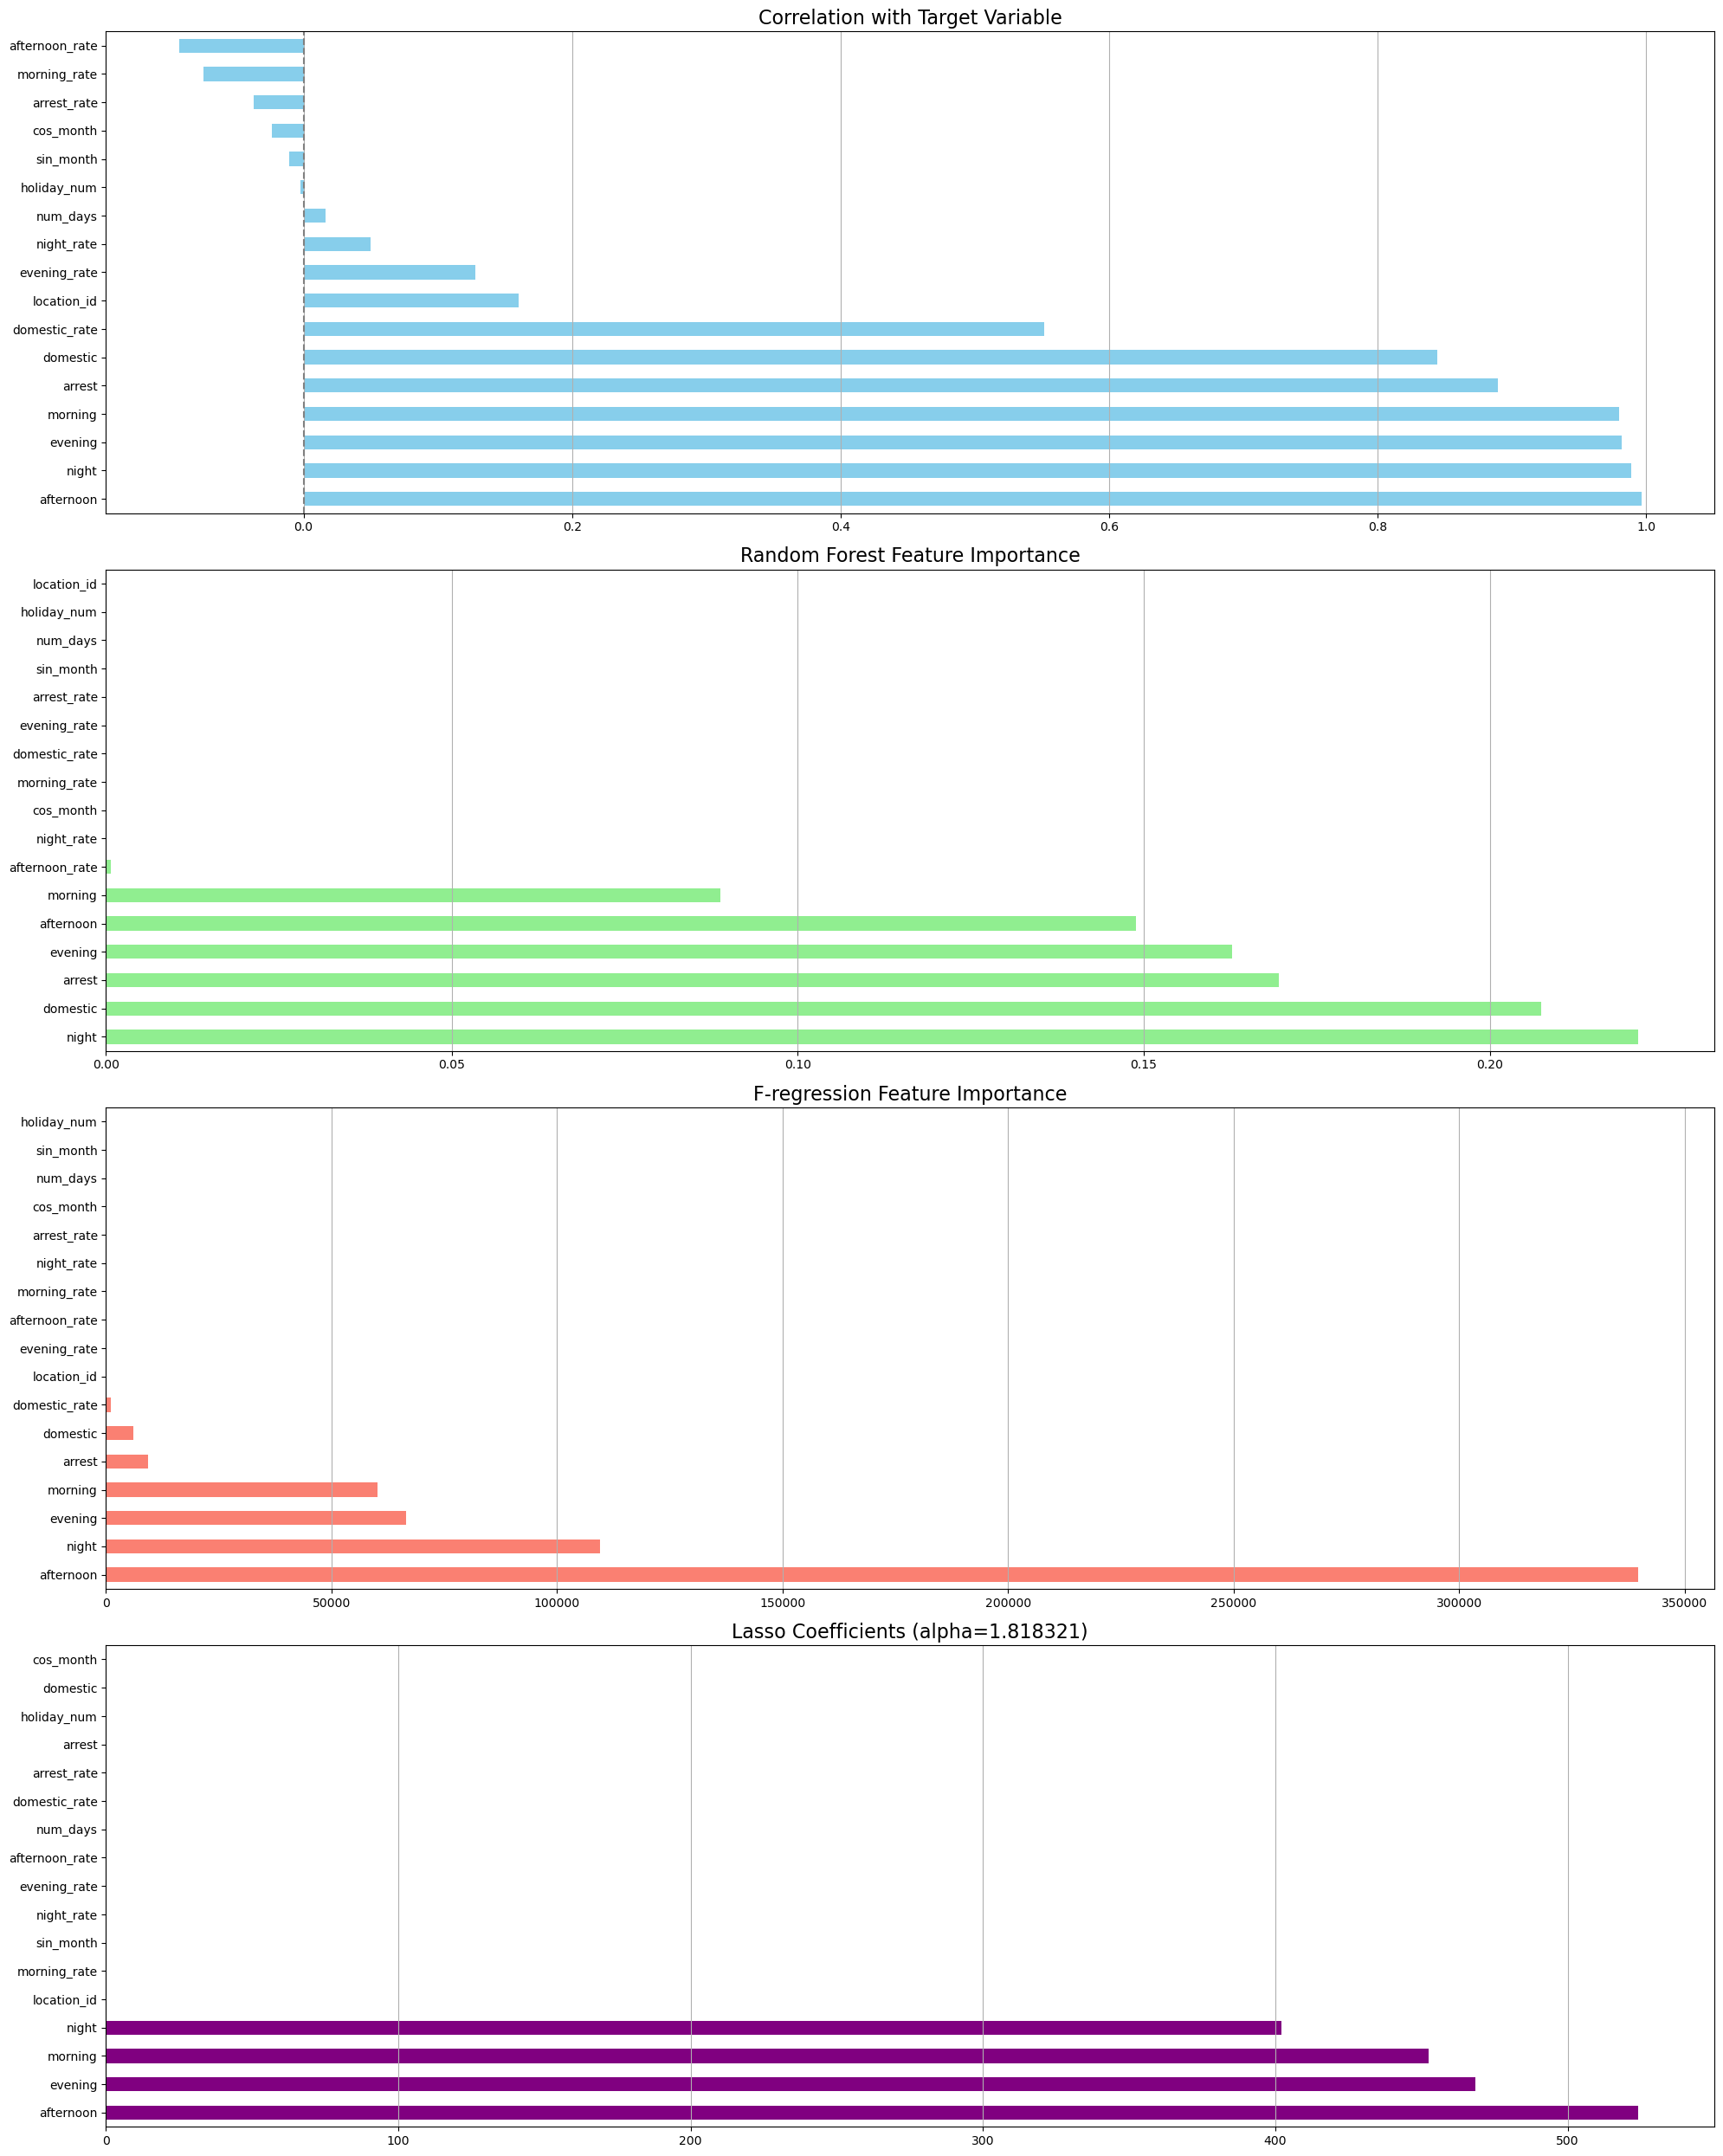

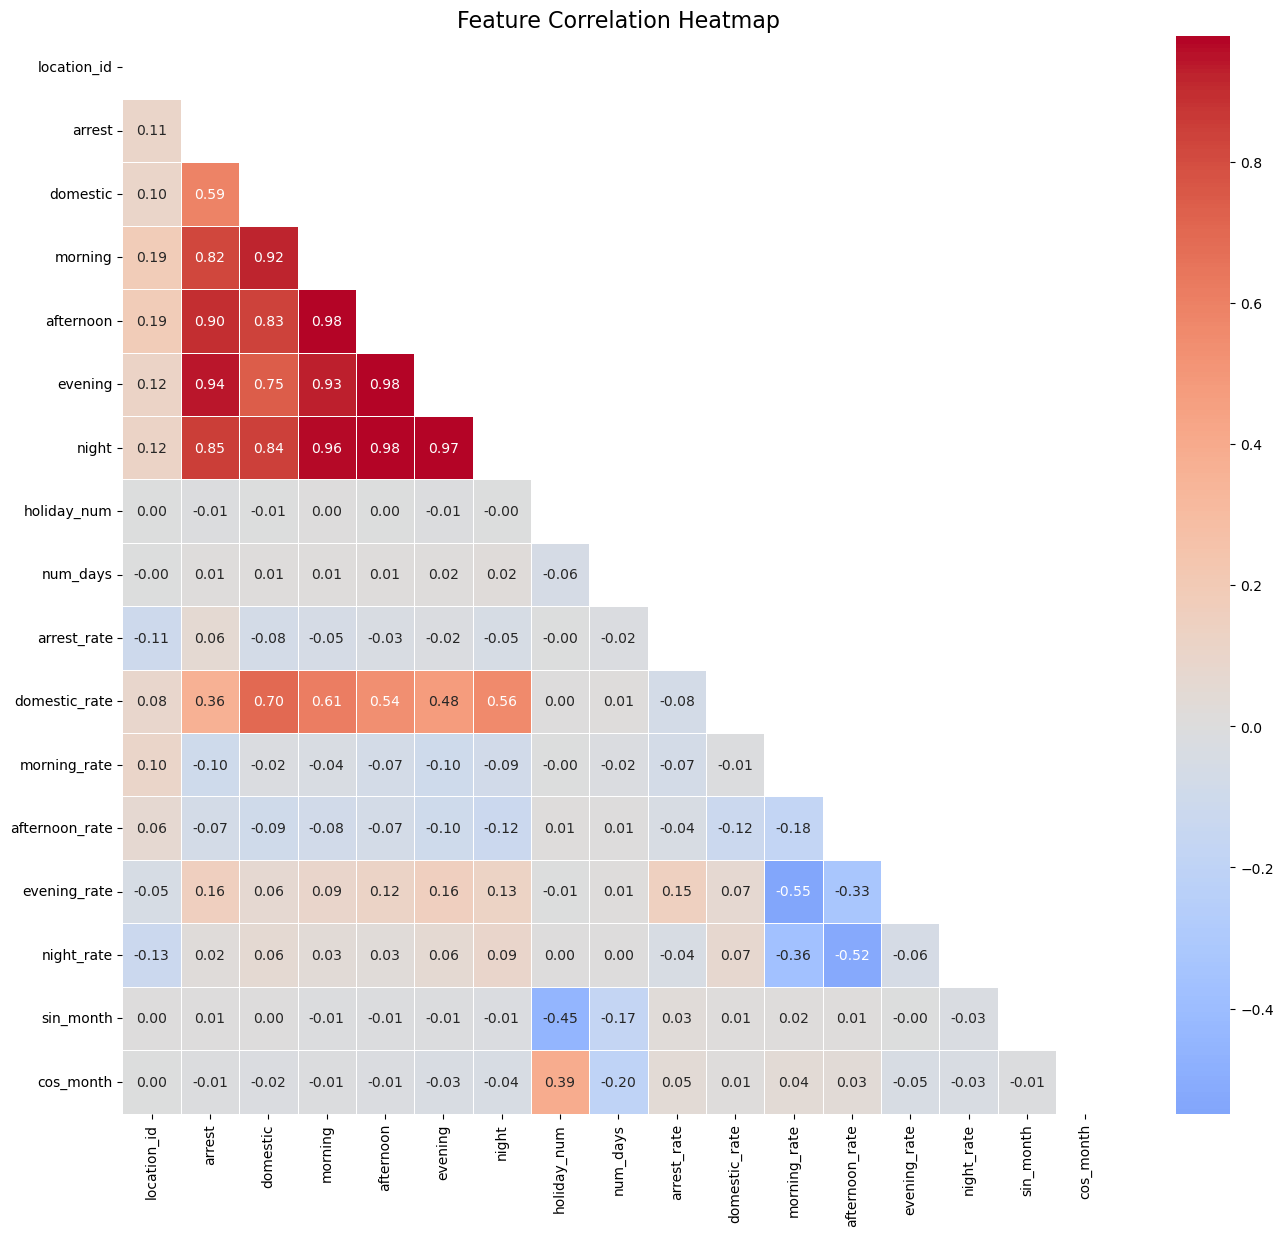

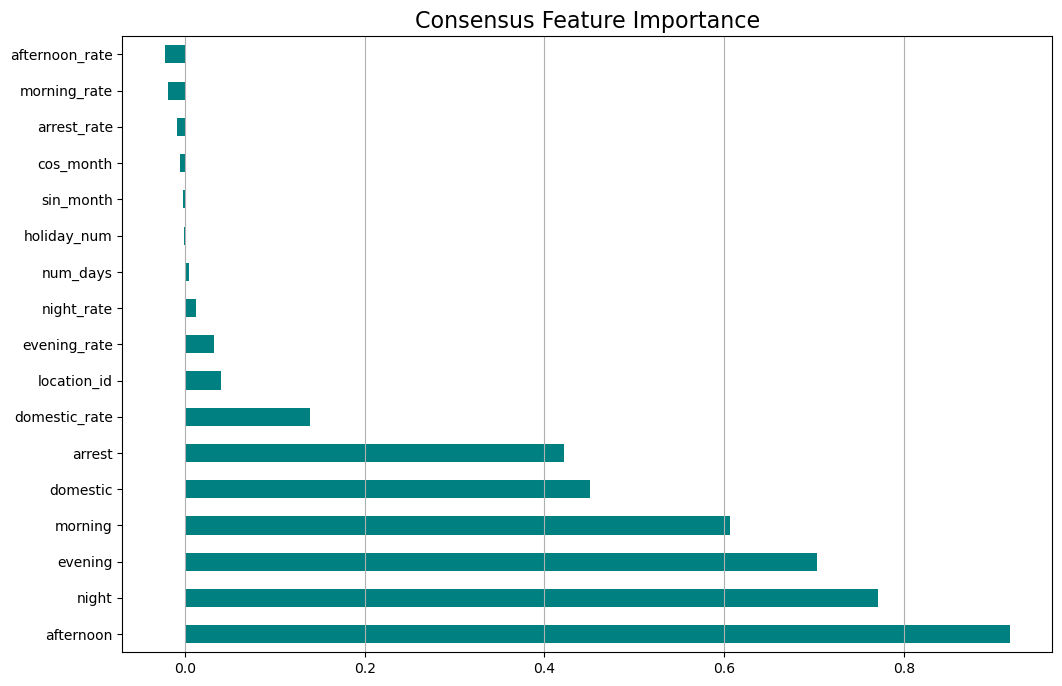

In [388]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")


def analyze_feature_importance(df, target_column="crime_count", exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []

    # Ensure target_column is not in exclude_columns
    if target_column in exclude_columns:
        exclude_columns.remove(target_column)

    # Add target_column to exclude_columns for feature extraction
    features_exclude = exclude_columns + [target_column]

    # Prepare data
    y = df[target_column].values
    X = df.drop(columns=features_exclude)
    feature_names = X.columns.tolist()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

    # 1. Correlation with target
    correlations = (
        df[feature_names + [target_column]]
        .corr()[target_column]
        .drop(target_column)
        .sort_values(ascending=False)
    )

    # 2. Multicollinearity check
    correlation_matrix = df[feature_names].corr()

    # 3. Feature importance from Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)
    rf_importances = pd.Series(
        rf.feature_importances_, index=feature_names
    ).sort_values(ascending=False)

    # 4. F-regression for linear relationships
    f_selector = SelectKBest(f_regression, k="all")
    f_selector.fit(X_scaled, y)
    f_scores = pd.Series(f_selector.scores_, index=feature_names).sort_values(
        ascending=False
    )

    # 5. Lasso regularization for feature selection
    lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
    lasso_cv.fit(X_scaled, y)
    alpha = lasso_cv.alpha_

    lasso = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    lasso.fit(X_scaled, y)
    lasso_coefs = pd.Series(np.abs(lasso.coef_), index=feature_names).sort_values(
        ascending=False
    )

    # Create visualizations
    plt.figure(figsize=(20, 25))

    # 1. Correlation with target
    plt.subplot(4, 1, 1)
    correlations.plot(kind="barh", color="skyblue")
    plt.title("Correlation with Target Variable", fontsize=16)
    plt.axvline(x=0, color="gray", linestyle="--")
    plt.grid(axis="x")

    # 2. Random Forest Feature Importance
    plt.subplot(4, 1, 2)
    rf_importances.plot(kind="barh", color="lightgreen")
    plt.title("Random Forest Feature Importance", fontsize=16)
    plt.grid(axis="x")

    # 3. F-regression scores
    plt.subplot(4, 1, 3)
    f_scores.plot(kind="barh", color="salmon")
    plt.title("F-regression Feature Importance", fontsize=16)
    plt.grid(axis="x")

    # 4. Lasso Coefficients
    plt.subplot(4, 1, 4)
    lasso_coefs.plot(kind="barh", color="purple")
    plt.title(f"Lasso Coefficients (alpha={alpha:.6f})", fontsize=16)
    plt.grid(axis="x")

    plt.tight_layout()

    # Correlation heatmap in a separate figure
    plt.figure(figsize=(16, 14))
    mask = np.triu(correlation_matrix)
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap="coolwarm",
        center=0,
        mask=mask,
        fmt=".2f",
        linewidths=0.5,
    )
    plt.title("Feature Correlation Heatmap", fontsize=16)

    # Create a consensus ranking
    results = pd.DataFrame(
        {
            "Correlation": correlations,
            "RandomForest": rf_importances,
            "F_Score": f_scores,
            "Lasso": lasso_coefs,
        }
    )

    # Normalize each column to range 0-1
    normalized_results = results.copy()
    for col in normalized_results.columns:
        if normalized_results[col].max() > 0:
            normalized_results[col] = (
                normalized_results[col] / normalized_results[col].max()
            )

    # Calculate consensus score (average of normalized scores)
    normalized_results["Consensus_Score"] = normalized_results.mean(axis=1)
    normalized_results = normalized_results.sort_values(
        "Consensus_Score", ascending=False
    )

    # Visualize consensus ranking
    plt.figure(figsize=(12, 8))
    normalized_results["Consensus_Score"].plot(kind="barh", color="teal")
    plt.title("Consensus Feature Importance", fontsize=16)
    plt.grid(axis="x")

    return {
        "correlations": correlations,
        "rf_importances": rf_importances,
        "f_scores": f_scores,
        "lasso_coefs": lasso_coefs,
        "correlation_matrix": correlation_matrix,
        "consensus_ranking": normalized_results,
        "lasso_alpha": alpha,
    }


def suggest_features_to_keep(results, correlation_threshold=0.7, top_n=15):
    top_features = results["consensus_ranking"].index[:top_n].tolist()
    corr_matrix = results["correlation_matrix"].loc[top_features, top_features]
    high_corr_pairs = []
    for i in range(len(top_features)):
        for j in range(i + 1, len(top_features)):
            corr = abs(corr_matrix.iloc[i, j])
            if corr > correlation_threshold:
                high_corr_pairs.append((top_features[i], top_features[j], corr))

    high_corr_pairs.sort(key=lambda x: x[2], reverse=True)

    to_remove = set()
    for feat1, feat2, corr in high_corr_pairs:
        score1 = results["consensus_ranking"].loc[feat1, "Consensus_Score"]
        score2 = results["consensus_ranking"].loc[feat2, "Consensus_Score"]

        if score1 >= score2 and feat2 not in to_remove:
            to_remove.add(feat2)
        elif feat1 not in to_remove:
            to_remove.add(feat1)

    features_to_keep = [f for f in top_features if f not in to_remove]

    lasso_zeros = results["lasso_coefs"][results["lasso_coefs"] < 0.001].index.tolist()

    return {
        "recommended_features": features_to_keep,
        "high_correlation_pairs": high_corr_pairs,
        "features_to_remove": list(to_remove),
        "lasso_eliminated": lasso_zeros,
        "top_by_method": {
            "correlation": results["correlations"].index[:5].tolist(),
            "random_forest": results["rf_importances"].index[:5].tolist(),
            "f_score": results["f_scores"].index[:5].tolist(),
            "lasso": results["lasso_coefs"].index[:5].tolist(),
        },
    }


exclude_cols = [
    "location_name",
    "Year",
    "Month",
    "time_id",
]  # columns to exclude from analysis
results = analyze_feature_importance(
    df_time, target_column="crime_count", exclude_columns=exclude_cols
)
suggestions = suggest_features_to_keep(results, correlation_threshold=0.7, top_n=15)

print("Recommended features to keep:")
for feature in suggestions["recommended_features"]:
    print(f"- {feature}")

In [389]:
df_time = df_time.sort_values(["location_id", "Year", "Month"])

In [394]:
df_pct = df_time.copy()
df_pct["crime_pct_change"] = df_pct["crime_count"].pct_change()
df_pct = df_pct[df_pct["Year"] >= 2018]
df_pct.sort_values(["Year", "Month", "location_name"])

,location_name,location_id,Year,Month,crime_count,arrest,domestic,morning,afternoon,evening,...,arrest_rate,domestic_rate,morning_rate,afternoon_rate,evening_rate,night_rate,sin_month,cos_month,time_id,crime_pct_change
1,ATM Separate from Bank,5,2018,1,49,0,0,15,9,7,...,0.000000,0.000000,0.306122,0.183673,0.142857,0.367347,0.0,1.000000,24217,-0.309859
86,Abandoned/Condemned Structure,1,2018,1,20,7,1,8,6,4,...,0.350000,0.050000,0.400000,0.300000,0.200000,0.100000,0.0,1.000000,24217,-0.166667
171,Air/Bus/Train Terminal,2,2018,1,518,128,16,106,225,107,...,0.247104,0.030888,0.204633,0.434363,0.206564,0.154440,0.0,1.000000,24217,0.095137
256,Arena/Stadium/Fairgrounds/Coliseum,4,2018,1,18,3,2,0,9,8,...,0.166667,0.111111,0.000000,0.500000,0.444444,0.055556,0.0,1.000000,24217,-0.400000
341,Auto Dealership New/Used,6,2018,1,20,1,2,3,4,7,...,0.050000,0.100000,0.150000,0.200000,0.350000,0.300000,0.0,1.000000,24217,2.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,Parking/Drop Lot/Garage,33,2024,12,757,99,44,190,249,181,...,0.130779,0.058124,0.250991,0.328930,0.239102,0.180978,-0.5,0.866025,24300,0.014745
2206,Residence/Home,35,2024,12,7369,681,3087,1904,2202,1535,...,0.092414,0.418917,0.258380,0.298819,0.208305,0.234496,-0.5,0.866025,24300,0.058308
2291,Restaurant,37,2024,12,494,39,14,73,208,104,...,0.078947,0.028340,0.147773,0.421053,0.210526,0.220648,-0.5,0.866025,24300,-0.078358
2376,School/College,38,2024,12,253,17,13,121,106,8,...,0.067194,0.051383,0.478261,0.418972,0.031621,0.071146,-0.5,0.866025,24300,-0.109155


In [396]:
df_lag = df_pct.copy()
for location_group, location_df in df_lag.groupby(["location_name"]):
    # Get indices for this location group
    indices = location_df.index

    # Make sure we're still working with time-ordered data
    temp_df = df_lag.loc[indices].sort_values("time_id")

    # Add lag features
    for lag in [1, 2, 3, 6, 12]:
        for feature in [
            "crime_pct_change",
            "domestic_rate",
            "arrest_rate",
            # "holiday_rate",
            "morning_rate",
            "afternoon_rate",
            "evening_rate",
            "night_rate",
        ]:
            df_lag.loc[indices, f"{feature}_lag{lag}"] = temp_df[feature].shift(lag)

    # df_time.loc[indices, "crime_pct_change_ma3"] = (
    #     temp_df["crime_pct_change"].rolling(window=3).mean().shift(1)
    # )
    # df_time.loc[indices, "crime_pct_change_ma6"] = (
    #     temp_df["crime_pct_change"].rolling(window=6).mean().shift(1)
    # )
# lag_columns = [
#     "crime_count_lag1",
#     "crime_count_lag2",
#     "crime_count_lag3",
#     "crime_count_lag6",
#     "crime_count_lag12",
#     "crime_count_ma3",
#     "crime_count_ma6",
# ]

df_lag = df_lag.dropna()
df_lag.sort_values(["Year", "Month", "location_id"], inplace=True)
df_lag

,location_name,location_id,Year,Month,crime_count,arrest,domestic,morning,afternoon,evening,...,afternoon_rate_lag6,evening_rate_lag6,night_rate_lag6,crime_pct_change_lag12,domestic_rate_lag12,arrest_rate_lag12,morning_rate_lag12,afternoon_rate_lag12,evening_rate_lag12,night_rate_lag12
98,Abandoned/Condemned Structure,1,2019,1,27,15,0,16,5,4,...,0.272727,0.272727,0.136364,-0.166667,0.050000,0.350000,0.400000,0.300000,0.200000,0.100000
183,Air/Bus/Train Terminal,2,2019,1,615,148,11,125,272,133,...,0.419118,0.197059,0.170588,0.095137,0.030888,0.247104,0.204633,0.434363,0.206564,0.154440
268,Arena/Stadium/Fairgrounds/Coliseum,4,2019,1,30,3,0,5,13,9,...,0.274510,0.529412,0.019608,-0.400000,0.111111,0.166667,0.000000,0.500000,0.444444,0.055556
13,ATM Separate from Bank,5,2019,1,25,2,0,9,6,6,...,0.300000,0.225000,0.225000,-0.309859,0.000000,0.000000,0.306122,0.183673,0.142857,0.367347
353,Auto Dealership New/Used,6,2019,1,18,1,2,8,3,4,...,0.250000,0.214286,0.250000,2.333333,0.100000,0.050000,0.150000,0.200000,0.350000,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,Restaurant,37,2024,12,494,39,14,73,208,104,...,0.422145,0.223183,0.224913,-0.081374,0.045276,0.094488,0.157480,0.411417,0.259843,0.171260
2376,School/College,38,2024,12,253,17,13,121,106,8,...,0.410448,0.126866,0.104478,-0.144703,0.042296,0.054381,0.425982,0.483384,0.036254,0.054381
2461,Service/Gas Station,41,2024,12,261,56,17,68,50,70,...,0.226190,0.238095,0.301587,0.061135,0.028807,0.164609,0.259259,0.242798,0.193416,0.304527
1951,Other/Unknown,98,2024,12,1479,245,80,407,598,255,...,0.377473,0.184615,0.165385,-0.010185,0.055949,0.120257,0.260450,0.413505,0.179421,0.146624


In [397]:
df_complete = df_lag.copy()

In [398]:
df_time_analysis = pd.DataFrame(
    {
        "Column": df_complete.columns,
        "Unique Values": df_complete.nunique().values,
        "Type": df_complete.dtypes.values,
        "Is Null": df_complete.isnull().sum().values,
    }
)
df_time_analysis

,Column,Unique Values,Type,Is Null
0,location_name,29,object,0
1,location_id,29,int64,0
2,Year,6,int32,0
3,Month,12,int32,0
4,crime_count,731,int64,0
5,arrest,337,int64,0
6,domestic,245,int64,0
7,morning,409,int64,0
8,afternoon,459,int64,0
9,evening,369,int64,0


In [399]:
df_complete.to_csv(f"{data_path}time_series_data.csv", index=False)